## AMAZON ALL BEAUTY PRODUCTS DATASET

In this project I will be focussing on testing if temporal features can be used to predict the success of beauty products avaliable on Amazon based on the product review features and review sentiment.


All the files in this project are stored in my Google Drive in a folder structure which includes :
CS6140_MidTerm
|----Data
|      |----Processed (to store processed Data sets)
|      |----Raw (to store raw data)
|----Models (Stores saved models)
|----Outputs
|     |----Results
|     |----Figures
|----Notebooks (Contains all three noteboks used for this project)

This is the first Notebook used in this assignment that exclusively focusses on Preparing the dataset for EDA and model trainnig based incorporating temporal, sentimental features in addition to existing product and review data available in the fetched Dataset.


In [1]:
#Setting up working directory in Google Drive to save all work

from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/CS6140_MidTerm')

print("Working Directory : ", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory :  /content/drive/MyDrive/CS6140_MidTerm


In [2]:
# Importing requirments
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting up Directories to download and store relevant files in respectiev directories
PROJECT_DIR = Path('/content/drive/MyDrive/CS6140_MidTerm')
RAW_DATA_DIR = PROJECT_DIR / 'Data' / 'Raw'
PROCESSED_DATA_DIR = PROJECT_DIR / 'Data' / 'Processed'

# Creating Directories if they do not exist
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

Question 1 : Data Set Selection

what was the dataset selected for this project ? what does it include?

The Mcauleylab dataset was used for this project which had accumulated reviews for Amazon product between May 1996 to  September 2023. The dataset includes a rich feature set that includes :

1.   User Reviews (ratings, text, helpfulness votes, etc.)
2.   Item Metadata (descriptions, price, raw image, etc.);
3.   Links (user-item / bought together graphs).

Further, this dataset also includes :


1.   Richer Metadata: More descriptive features in item metadata
2.   Fine-grained Timestamp: Interaction timestamp at the second or finer level

These rich descriptive features pushed me towards the dataset to verify if temporal features provide better signals to predict early success of products.


To help with the resource constraints of working in Colab I focused on single product category 'All_beauty' , because beauty category had a good amount of reviews and is a very user specific segment which could have a good amount of sentiment (positive, negative, neutral) in text based reviews that can complement ratings provided by users.

Further details about this dataset are available at : https://amazon-reviews-2023.github.io/#load-user-reviews





In [ ]:
# ============================================================================
# STEP 1: Download Dataset
# ============================================================================

'''
This function is created to download the dataset using wget method to download both the product review data and associated m
eta data for the product.
'''
categories = ['All_Beauty']

def download_datasets(categories):
  os.chdir(RAW_DATA_DIR)

  for category in categories:

    print(f'Downloading {category} dataset...')

    !wget -q https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/{category}.jsonl.gz
    !wget -q https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_{category}.jsonl.gz

    print(f'Downloaded {category} dataset')

    # Unzip the dataset
    print(f'Unzipping {category} dataset...')
    !gunzip {category}.jsonl.gz
    !gunzip meta_{category}.jsonl.gz

  print(f'The dataset / datasets are saved at : {RAW_DATA_DIR}')

download_datasets(categories)


Downloaded All_Beauty dataset
Unzipping All_Beauty dataset...
The dataset / datasets are saved at : /content/drive/MyDrive/CS6140_MidTerm/Data/Raw


In [6]:
# ============================================================================
# STEP 2: Verify Downloaded Files
# ============================================================================

def fetch_files(data_dir=RAW_DATA_DIR):
    """
    Find all downloaded .jsonl files
    Returns dictionary mapping review files to their metadata files
    """
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.jsonl')]
    review_files = [f for f in all_files if not 'meta' in f]
    meta_data_files = [f for f in all_files if 'meta' in f]

    # Create pairs
    file_pairs = {}
    for review_file in review_files:
        meta_file = f"meta_{review_file}"
        if meta_file in meta_data_files:
            file_pairs[review_file] = meta_file

    return file_pairs

file_pairs = fetch_files()
print(f"\nFound File Pairs:")
for review, meta in file_pairs.items():
    print(f"   Review: {review}")
    print(f"   Meta:   {meta}")


Found File Pairs:
   Review: All_Beauty.jsonl
   Meta:   meta_All_Beauty.jsonl


In [8]:
# ============================================================================
# STEP 3: Convert JSONL to DataFrame (Efficient Loading)
# ============================================================================

def convert_to_dataframe(filename, data_dir=RAW_DATA_DIR, nrows=None):
    """
    Convert JSONL file to pandas DataFrame
    """
    filepath = data_dir / filename

    print(f"Loading {filename}...")
    reviews = []

    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            reviews.append(json.loads(line))

    df = pd.DataFrame(reviews)
    print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

    return df

In [9]:
# ============================================================================
# STEP 4: Load and Save as CSV
# ============================================================================
def process_and_save_datasets(file_pairs, save_format='csv', nrows=None):
    """
    Load JSONL files and save as CSV in processed directory

    """

    for review_file, meta_file in file_pairs.items():
        category_name = review_file.replace('.jsonl', '')

        reviews_df = convert_to_dataframe(review_file, nrows=nrows)


        meta_df = convert_to_dataframe(meta_file, nrows=nrows)

        review_path = PROCESSED_DATA_DIR / f"{category_name}_reviews.csv"
        meta_path = PROCESSED_DATA_DIR / f"{category_name}_meta.csv"

        reviews_df.to_csv(review_path, index=False)
        meta_df.to_csv(meta_path, index=False)

        print(f"Reviews {category_name} saved to {review_path}")
        print(f"Meta {category_name} saved to {meta_path}")


def load_category_dataset(category):
    """
    Load reviews and metadata for a given category
    """
    review_path = PROCESSED_DATA_DIR / f"{category}_reviews.csv"
    meta_path = PROCESSED_DATA_DIR / f"{category}_meta.csv"

    reviews_df = pd.read_csv(review_path)
    meta_df = pd.read_csv(meta_path)


    # Printing Memory Related details for understanding the size of the dataset
    print()
    print(f"Review Dataset Shape : {reviews_df.shape[0]} rows X {reviews_df.shape[1]} columns")

    # Setting deep to True to find the actual space utiolized by strings in the dataset
    print(f"Memory Usage - Reviews Dataset : {reviews_df.memory_usage(deep=True).sum()/1e6 : .2f} MB")
    print(f"Meta Dataset Shape : {meta_df.shape[0]} rows X {meta_df.shape[1]} columns")
    print(f"Memory Usage - Reviews Meta Dataset : {meta_df.memory_usage(deep=True).sum()/1e6 : .2f} MB")

    return reviews_df, meta_df



process_and_save_datasets(file_pairs, save_format='csv', nrows=None)
#reviews_df, meta_df = load_category_dataset('All_Beauty')




Loading All_Beauty.jsonl...
Loaded 701,528 rows, 10 columns
Loading meta_All_Beauty.jsonl...
Loaded 112,590 rows, 14 columns
Reviews All_Beauty saved to /content/drive/MyDrive/CS6140_MidTerm/Data/Processed/All_Beauty_reviews.csv
Meta All_Beauty saved to /content/drive/MyDrive/CS6140_MidTerm/Data/Processed/All_Beauty_meta.csv


In [10]:
# Loading review and meta data from csv files saved earlier

reviews_df, meta_df = load_category_dataset('All_Beauty')

# Lets understand the individual datasets
# Focussing on review dataset


reviews_df.head()


Review Dataset Shape : 701528 rows X 10 columns
Memory Usage - Reviews Dataset :  459.86 MB
Meta Dataset Shape : 112590 rows X 14 columns
Memory Usage - Reviews Meta Dataset :  254.63 MB


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [11]:
# Testing Verified Purchase
print("Verified Purchase Statistics : ")
print(f"Data Type : {reviews_df['verified_purchase'].dtype}")
print(f"Unique Values : {reviews_df['verified_purchase'].unique()}")
print(f"Value Counts :")
counts = reviews_df['verified_purchase'].value_counts()
percentages = reviews_df['verified_purchase'].value_counts(normalize=True) * 100
print(pd.concat([counts, percentages.round(2)], axis=1))

Verified Purchase Statistics : 
Data Type : bool
Unique Values : [ True False]
Value Counts :
                    count  proportion
verified_purchase                    
True               634969       90.51
False               66559        9.49


In [12]:
# Now that most purchases are verified , we can also check for rating comparison between verified and non - verified
print("Rating Comparison between Verified and Non - Verified Purchases : ")
print(reviews_df.groupby('verified_purchase')['rating'].agg(['mean', 'median', 'std', 'count', 'min', 'max']))

Rating Comparison between Verified and Non - Verified Purchases : 
                       mean  median       std   count  min  max
verified_purchase                                              
False              4.075482     5.0  1.380086   66559  1.0  5.0
True               3.948166     5.0  1.505427  634969  1.0  5.0


In [13]:
# This tells us there is a skew in the ratings of the dataset.
# The median (50% percentile) is 5.0 which suggests more than half the ratings in the dataset is 5 stars, which
# reflects very similar to real world ecommerce purchases where happy customers put in a 5 star rating.

# Rating Distribution
rating_dist  = reviews_df['rating'].value_counts().sort_index()
rating_dist_pct = reviews_df['rating'].value_counts(normalize=True).sort_index() * 100
print(pd.concat([rating_dist, rating_dist_pct.round(2)], axis=1))

         count  proportion
rating                    
1.0     102080       14.55
2.0      43034        6.13
3.0      56307        8.03
4.0      79381       11.32
5.0     420726       59.97


In [14]:
print(rating_dist_pct.cumsum())

rating
1.0     14.551094
2.0     20.685418
3.0     28.711755
4.0     40.027198
5.0    100.000000
Name: proportion, dtype: float64


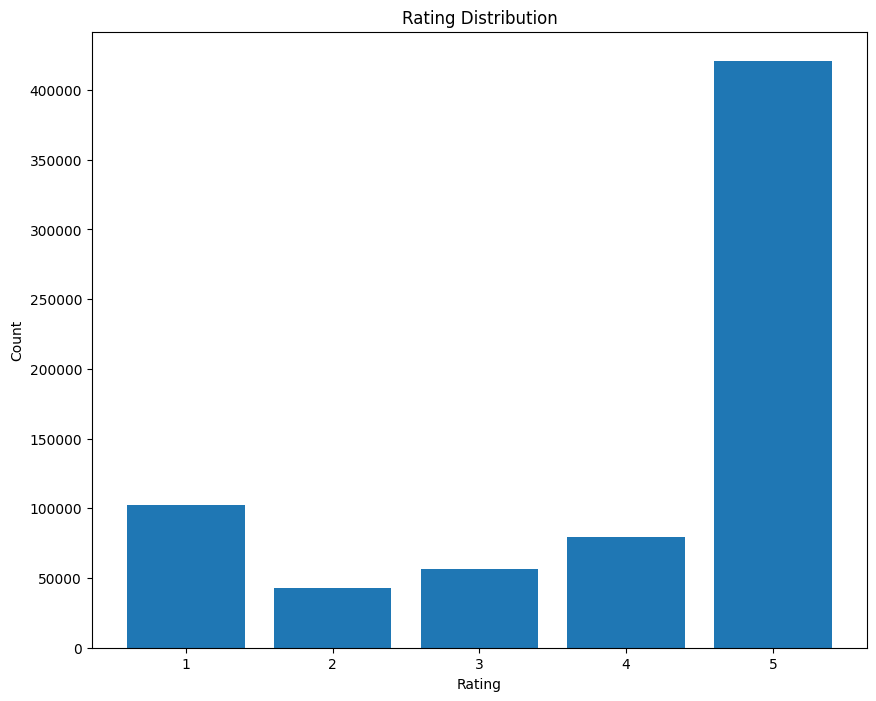

In [15]:
# Plotting graph for ranking distribution
plt.figure(figsize = (10, 8))
plt.bar(rating_dist.index, rating_dist.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

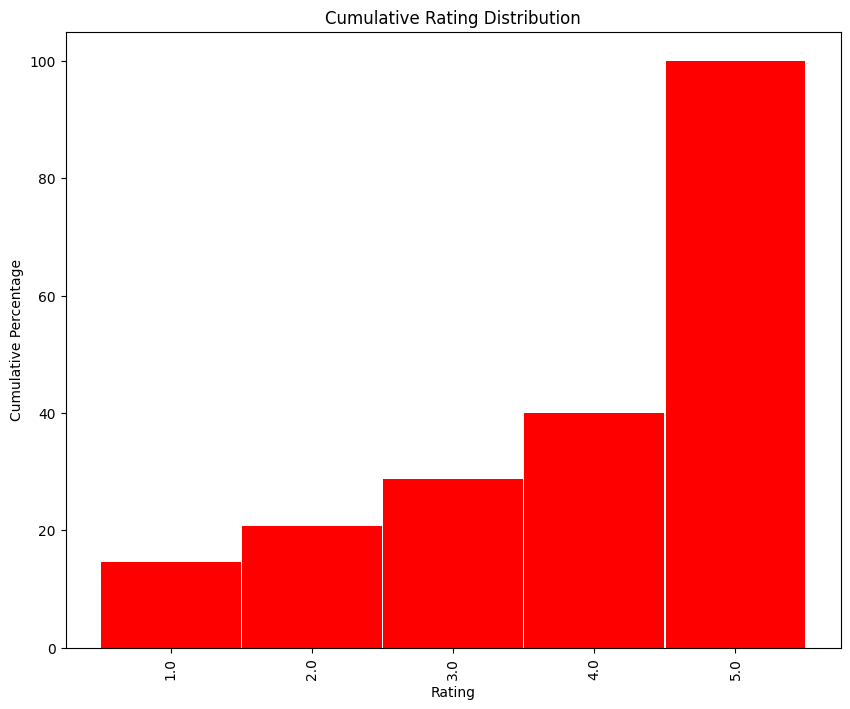

In [16]:
# Plotting cummulative histogram of ratings
plt.figure(figsize = (10, 8))
rating_dist_pct.cumsum().plot(kind = "bar", width = 0.99, color = "red")
plt.xlabel('Rating')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Rating Distribution')
plt.show()

Rating Distribution Summary:



1.   60% are 5-star (huge positive skew)
2.   15% are 1-star (bimodal - with two peaks)
3.   25% are 2-4 stars (the middle is sparse)

This is a classic "love it or hate it" pattern in Beauty products!

What this tells you:

Beauty products are highly personal/subjective
Products either work great (5 star) or fail badly (1 star)
Few people felt okayish about them (middle ratings rare)

These could happens with Beauty:

Skin type compatibility : works perfectly or doesnot work well with certain customers
Color match : perfect shade or wrong tone
Scent : love it or hate it
Allergic reactions : great or terrible according to personal opinion of the customer

It is a weak signal but will be saving the values for later.

In [17]:
# Working on understanding the relevance of helpful votes

print("Helpful Votes Statistics : ")
print(f"Data Type : {reviews_df['helpful_vote'].dtype}")
print(f"Unique Values : {reviews_df['helpful_vote'].unique()}")
print(f"Value Counts :")
counts = reviews_df['helpful_vote'].value_counts().sort_index()
percentages = reviews_df['helpful_vote'].value_counts(normalize=True) * 100
print(pd.concat([counts, percentages.round(2)], axis=1))

Helpful Votes Statistics : 
Data Type : int64
Unique Values : [  0   1   2 430   4   3   8   5  13   6  16   9   7  49  11  15  58  24
  20  34  10  21  50  19  52  23  14  38  18  40  36  31  30  22  37  43
  29  51 120  47  32  12  33  17  92  42  41  63  27  28  25 133  57  26
  64  71  35 114  89  53 101  60  72  45  46 419  59 117  44  65  39  74
  99  56  54  48  69  75 178  55  67 111 150 143  73  79 148 177  80 266
 154  86  66  95  81 165 140 171  76  85  62 113  61 404 166 124 118  90
 607 315  70  88 112 426 102 158 145 129  98 107 109  78 185 314 187 123
 155 142 126 218 127 104 172 147 331 106  68 141 159 175 173 241 135 646
 119 151 149  83  82 136 134 132  93 121 594 399 389 473 351 467 435 354
 234 519  94 131 181 103 105 431 100 190  77 138 367 197 125 152 244 409
 249  91  87 373 144 233 179  84 116 200 203 279 193  96 161 466 122 130
 552 184 108 110 163 434 365 160 139 183 411 176 267 170 156 208 128 168
 188 323 137  97 186 350 230 381 283 201 167 424 169 334 164 4

In [18]:
# Now that we can see helpful ratings is mostly sparse it can be due to cases where
# Users do not actively engage with previoius reviews and just see them for educated guess if the product will suit them

# To undestand the effect of helpful votes - will be studying its distribution


print("Helpful Votes Distribution By Rating: ")
votes_by_rating = reviews_df.groupby('rating')['helpful_vote'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('pct_with_votes', lambda x: (x>0).mean() * 100)
])
print(votes_by_rating)


Helpful Votes Distribution By Rating: 
         count      mean  pct_with_votes
rating                                  
1.0     102080  0.963852       30.027429
2.0      43034  0.748339       26.660315
3.0      56307  0.732005       26.113982
4.0      79381  0.930550       27.184087
5.0     420726  0.956071       25.914966


Conclusion: Helpful votes are NOT rating-specific

Getting a helpful vote is independent of the rating
1-star reviews aren't more/less likely to get votes than 5-star reviews
People vote "helpful" roughly equally across all rating levels
This tells me that Helpful votes signal about review quality or rating sentiment

Before considering dropping the entire field, I will also be checking product wise if helpful votes assist with identifying the rating, or if helpful votes assist with products having a higher rating.

In [19]:
# grouping by asin id to group reviews per product together
# aggregating helpful votes to check if they vary by prouduct
product_stats = reviews_df.groupby('asin').agg({
    'rating': ['mean', 'min', 'max', 'std', 'count'],
    'helpful_vote': ['sum', 'mean', 'max'],
    'verified_purchase': ['mean', 'count']
}).reset_index()

product_stats.columns = ['asin', 'rating_mean', 'rating_min', 'rating_max', 'rating_std', 'review_count',
                         'helpful_total', 'helpful_avg', 'helpful_max', 'verified_purchases_mean', 'verified_purchases_count']

product_stats['rating_range'] = product_stats['rating_max'] - product_stats['rating_min']
product_stats['helpful_ratio'] = product_stats['helpful_total'] / product_stats['review_count']
product_stats['verified_purchases_ratio'] = product_stats['verified_purchases_mean'] * product_stats['verified_purchases_count']

product_stats.head()

,asin,rating_mean,rating_min,rating_max,rating_std,review_count,helpful_total,helpful_avg,helpful_max,verified_purchases_mean,verified_purchases_count,rating_range,helpful_ratio,verified_purchases_ratio
0,0005946468,5.000000,5.0,5.0,NaN,1,0,0.000000,0,1.0,1,0.0,0.000000,1.0
1,0123034892,5.000000,5.0,5.0,NaN,1,0,0.000000,0,1.0,1,0.0,0.000000,1.0
2,0124784577,4.333333,3.0,5.0,1.154701,3,1,0.333333,1,1.0,3,2.0,0.333333,3.0
3,0515059560,4.000000,4.0,4.0,NaN,1,1,1.000000,1,1.0,1,0.0,1.000000,1.0
4,0615675026,2.000000,2.0,2.0,NaN,1,6,6.000000,6,1.0,1,0.0,6.000000,1.0


In [20]:
product_stats.head(10)

,asin,rating_mean,rating_min,rating_max,rating_std,review_count,helpful_total,helpful_avg,helpful_max,verified_purchases_mean,verified_purchases_count,rating_range,helpful_ratio,verified_purchases_ratio
0,0005946468,5.000000,5.0,5.0,NaN,1,0,0.000000,0,1.000000,1,0.0,0.000000,1.0
1,0123034892,5.000000,5.0,5.0,NaN,1,0,0.000000,0,1.000000,1,0.0,0.000000,1.0
2,0124784577,4.333333,3.0,5.0,1.154701,3,1,0.333333,1,1.000000,3,2.0,0.333333,3.0
3,0515059560,4.000000,4.0,4.0,NaN,1,1,1.000000,1,1.000000,1,0.0,1.000000,1.0
4,0615675026,2.000000,2.0,2.0,NaN,1,6,6.000000,6,1.000000,1,0.0,6.000000,1.0
5,0692508988,5.000000,5.0,5.0,NaN,1,0,0.000000,0,1.000000,1,0.0,0.000000,1.0
6,069267599X,4.780488,2.0,5.0,0.652388,41,85,2.073171,18,0.975610,41,3.0,2.073171,40.0
7,0764490117,5.000000,5.0,5.0,0.000000,2,2,1.000000,2,0.500000,2,0.0,1.000000,1.0
8,0816091846,4.642857,1.0,5.0,1.081818,14,20,1.428571,5,0.857143,14,4.0,1.428571,12.0
9,0963416391,5.000000,5.0,5.0,NaN,1,3,3.000000,3,0.000000,1,0.0,3.000000,0.0


In [21]:
# Printing the correlations values between avg helpful votes to all the other features in the grouped dataset
correlations = product_stats[['rating_mean', 'rating_std', 'review_count', 'helpful_avg', 'helpful_total', 'verified_purchases_mean']].corr()
print(correlations['helpful_avg'].sort_values(ascending=False))


helpful_avg                1.000000
helpful_total              0.214007
rating_std                 0.041755
review_count               0.038857
rating_mean                0.006120
verified_purchases_mean   -0.025313
Name: helpful_avg, dtype: float64


In [22]:
print(correlations['helpful_total'].sort_values(ascending=False)) # printing sorted correlation for total helpful since avg had lower values

helpful_total              1.000000
review_count               0.662096
helpful_avg                0.214007
rating_std                 0.041132
rating_mean                0.010932
verified_purchases_mean   -0.006890
Name: helpful_total, dtype: float64


In [23]:
# Splitting values into high engagement and low engagement based on helpful ratio to check if that gives a different outlook about products with
# more votes
high_engagement_products =  product_stats[product_stats['helpful_ratio'] > 1]
low_engagement_products =  product_stats[product_stats['helpful_ratio'] < 1]

print("\nHigh engagement products:")
print(f"  Count: {len(high_engagement_products)}")
print(f"  Avg rating: {high_engagement_products['rating_mean'].mean():.2f}")
print(f"  Avg rating std: {high_engagement_products['rating_std'].mean():.2f}")
print(f"  Avg review count: {high_engagement_products['review_count'].mean():.0f}")

print("\nLow engagement products:")
print(f"  Count: {len(low_engagement_products)}")
print(f"  Avg rating: {low_engagement_products['rating_mean'].mean():.2f}")
print(f"  Avg rating std: {low_engagement_products['rating_std'].mean():.2f}")
print(f"  Avg review count: {low_engagement_products['review_count'].mean():.0f}")


High engagement products:
  Count: 15560
  Avg rating: 3.84
  Avg rating std: 1.21
  Avg review count: 12

Low engagement products:
  Count: 90641
  Avg rating: 3.82
  Avg rating std: 1.08
  Avg review count: 5


 Total helpful votes show strong correlation with review count (r=0.66) but negligible correlation with product quality metrics (rating_mean: r=0.01, rating_std: r=0.04).

 Analysis of 112,590 products revealed that high-engagement products (helpful_avg >1.0, n=15,560) and low-engagement products (helpful_avg ≤0.5, n=90,641) have nearly identical average ratings (3.84 vs 3.82) and similar rating variance patterns.

This implies that helpful votes primarily reflect product popularity rather than quality or success potential. At the review level, 73% of reviews have zero helpful votes, indicating high sparsity.


Since the feature is realy sparse, will be dropping all helpful vote features due to redundancy with review count and lack of predictive signal for product success. Review count will serve as the primary popularity/engagement metric.

In [24]:
# Step 2 : Performing Temporal Analysis


# Printting Time stamps in the dataset
print(reviews_df['timestamp'].head())

# The timestamps are not in human readable format these are in unix time - transforming them into date time format

0    1588687728923
1    1588615855070
2    1589665266052
3    1643393630220
4    1609322563534
Name: timestamp, dtype: int64


In [25]:
reviews_df['review_date'] = pd.to_datetime(reviews_df['timestamp'], unit='ms')
print(reviews_df['review_date'].head())

0   2020-05-05 14:08:48.923
1   2020-05-04 18:10:55.070
2   2020-05-16 21:41:06.052
3   2022-01-28 18:13:50.220
4   2020-12-30 10:02:43.534
Name: review_date, dtype: datetime64[ns]


In [26]:
print("Printing the minimum month and year in the dataset")
print(f"Minimum Date Year : {reviews_df['review_date'].min().year} Month : {reviews_df['review_date'].min().month}")
print("Printing the maximum month and year in the dataset")
print(f"Maximum Date Year : {reviews_df['review_date'].max().year} Month : {reviews_df['review_date'].max().month}")

Printing the minimum month and year in the dataset
Minimum Date Year : 2000 Month : 11
Printing the maximum month and year in the dataset
Maximum Date Year : 2023 Month : 9


In [27]:
# The timestamps do fit in the time stamp coverage of the dataset which startes from May 1996 - Sept 2023

# Now that reviews are in a 23 years time span lets analyze the reviews by year
reviews_by_year = reviews_df['review_date'].dt.year.value_counts().reset_index()
reviews_by_year.columns = ['review_date', 'count']
print(reviews_by_year)



    review_date   count
0          2020  126753
1          2021  124897
2          2019   99120
3          2018   72707
4          2017   68035
5          2016   62747
6          2022   61581
7          2015   36239
8          2014   16279
9          2023   14405
10         2013    7948
11         2012    2803
12         2011    1877
13         2010    1586
14         2008    1269
15         2009    1207
16         2007    1162
17         2006     419
18         2005     267
19         2004     134
20         2003      56
21         2002      24
22         2001      12
23         2000       1


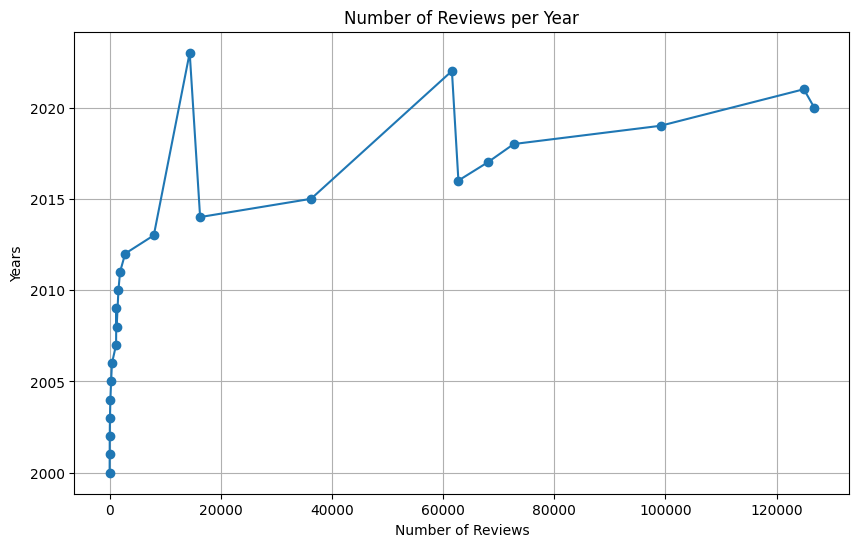

In [28]:
# Plotting a line plot for the reviews per year
plt.figure(figsize=(10, 6))
plt.plot(reviews_by_year['count'], reviews_by_year['review_date'], marker='o')
plt.xlabel('Number of Reviews')
plt.ylabel('Years')
plt.title('Number of Reviews per Year')
plt.grid(True)
plt.show()

In [29]:
# Product launches by year
# To identify that creating a field to determine closest product launch date through first review for the product

product_first_review = reviews_df.groupby('asin')['review_date'].min().reset_index()
product_first_review.columns = ['asin', 'first_review_date']

product_launch_years = product_first_review['first_review_date'].dt.year.value_counts().reset_index()
product_launch_years.columns = ['review_date', 'count']
print(product_launch_years)


    review_date  count
0          2021  22414
1          2020  20861
2          2019  17571
3          2018  11921
4          2017   9951
5          2022   9596
6          2016   9107
7          2015   5370
8          2014   3138
9          2023   1772
10         2013   1667
11         2012    755
12         2011    478
13         2010    376
14         2009    251
15         2008    180
16         2007    160
17         2006     48
18         2005     39
19         2004     31
20         2003     14
21         2002      5
22         2001      3
23         2000      1


In [30]:
# merging the product launch fields with review dataset
reviews_df = reviews_df.merge(product_first_review, on='asin', how='left')

In [31]:
reviews_df['first_review_date'].isna().sum() # Checking fo rnull values generated if any

np.int64(0)

In [32]:
# computing days since launch to study review accumulation between different periods
reviews_df['days_since_launch'] = (reviews_df['review_date'] - reviews_df['first_review_date']).dt.days

print("Added days sisnce launch for products ")
print(reviews_df[['asin', 'review_date', 'first_review_date', 'days_since_launch']].head())


Added days sisnce launch for products 
         asin             review_date       first_review_date  \
0  B00YQ6X8EO 2020-05-05 14:08:48.923 2015-10-03 23:44:21.000   
1  B081TJ8YS3 2020-05-04 18:10:55.070 2020-01-28 04:18:50.289   
2  B07PNNCSP9 2020-05-16 21:41:06.052 2019-12-22 21:22:51.437   
3  B09JS339BZ 2022-01-28 18:13:50.220 2022-01-28 18:13:50.220   
4  B08BZ63GMJ 2020-12-30 10:02:43.534 2020-11-04 20:44:32.526   

   days_since_launch  
0               1675  
1                 97  
2                146  
3                  0  
4                 55  


In [33]:
(reviews_df['days_since_launch'] < 0).sum() # Check for any wrong values in the dataset.

np.int64(0)

In [34]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  float64       
 1   title              701368 non-null  object        
 2   text               701316 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  int64         
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
 10  review_date        701528 non-null  datetime64[ns]
 11  first_review_date  701528 non-null  datetime64[ns]
 12  days_since_launch  701528 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(1), i

In [35]:
print(reviews_df['asin'].nunique())

115709


In [36]:
reviews_df['first_review_date'].dt.year.value_counts()  # printing the counts for first review date to check for any pattern

,count
first_review_date,
2020,108218
2019,98997
2016,80929
2018,78680
2021,75047
2017,72935
2015,59431
2014,33909
2022,27662


In [37]:
# 2013: The company launched the dedicated Amazon Premium Beauty store to provide a more curated and high-end selection.

# Printing the size of entire dataset and early reviews (90 days after launch)

print(f"Total Number of Reviews : {len(reviews_df)}")
print(f"Reviews within 90 days of launch : {len(reviews_df[(reviews_df['first_review_date'].dt.year >= 2013) & (reviews_df['days_since_launch'] <= 90)])}")
print(f"Percentage of early reviews in the dataset {round(len(reviews_df[(reviews_df['first_review_date'].dt.year >= 2013) & (reviews_df['days_since_launch'] <= 90)])/len(reviews_df) * 100, 2) }")


Total Number of Reviews : 701528
Reviews within 90 days of launch : 245392
Percentage of early reviews in the dataset 34.98


In [38]:
# Review Distribution By Time Window
print("Review Distribution by Week : ")

windows = [
    (0, 7, "Week 1"),
    (8, 30, "Days 8-30"),
    (31, 60, "Days 31-60"),
    (61, 90, "Days 61-90"),
    (91, 180, "Days 91-180"),
    (181, 365, "Days 181-365"),
    (366, float('inf'), "Year 2+")
]

for start, end, label in windows:
  if end == float('inf'):
    count = (reviews_df['days_since_launch'] >= start).sum()
  else:
    count = ((reviews_df['days_since_launch'] >= start) & (reviews_df['days_since_launch'] <= end)).sum()
  pct = round(count / len(reviews_df) * 100, 2)
  print(f"{label} : {count} ({pct}%) ")

Review Distribution by Week : 
Week 1 : 132367 (18.87%) 
Days 8-30 : 37406 (5.33%) 
Days 31-60 : 41962 (5.98%) 
Days 61-90 : 36934 (5.26%) 
Days 91-180 : 86394 (12.32%) 
Days 181-365 : 114218 (16.28%) 
Year 2+ : 252247 (35.96%) 


In [39]:
# Updated the block to identify hwo many products have a good set of reviews or traction among public including periods where
# most reviews have accumulated from public and to balance a good amount of data accumulation to study / build early signals
# for prediction

early_product_reviews = reviews_df[(reviews_df['first_review_date'].dt.year >= 2013) & (reviews_df['days_since_launch'] <= 90)]


print(early_product_reviews['first_review_date'].min())
print(early_product_reviews['first_review_date'].max())
print(early_product_reviews['days_since_launch'].min())
print(early_product_reviews['days_since_launch'].max())

print(len(early_product_reviews))

2013-01-01 05:58:35
2023-09-01 22:11:38.819000
0
90
245392


In [40]:
# grouping products and aggregating reviews in 90 days and rating in same time period
product_review_counts = early_product_reviews.groupby('asin').agg(
    review_count_90d=('asin', 'size'),
    avg_rating = ('rating', 'mean')
).reset_index()

asin_to_parent = early_product_reviews[['asin', 'parent_asin']].drop_duplicates('asin')

product_review_counts = product_review_counts.merge(asin_to_parent, on='asin', how='left')

print(product_review_counts.head())

print(product_review_counts['review_count_90d'].min())
print(product_review_counts['review_count_90d'].max())
print(product_review_counts['review_count_90d'].nunique())
print(product_review_counts['review_count_90d'].std())

product_review_counts['review_count_90d'].value_counts().head(25)

         asin  review_count_90d  avg_rating parent_asin
0  0005946468                 1    5.000000  0005946468
1  0123034892                 1    5.000000  0123034892
2  0124784577                 3    4.333333  0124784577
3  0515059560                 1    4.000000  0515059560
4  0615675026                 1    2.000000  B00J29O4A2
1
342
111
4.175146073409488


,count
review_count_90d,
1,73262
2,19337
3,7666
4,4036
5,2400
6,1506
7,988
8,754
9,563


In [41]:
# Segmenting products to categories to define success metrics
high_engagement_products =  product_review_counts[product_review_counts['review_count_90d'] >= 7]
low_engagement_products =  product_review_counts[(product_review_counts['review_count_90d'] >= 2) & (product_review_counts['review_count_90d']) < 7]


print("Product Segmentation : ")
print(f"High Engagement Products : {len(high_engagement_products)} products")
print(f"Low Engagement Products : {len(low_engagement_products)} products")
print(f"Least Engagement Products (<2) : {len(product_review_counts[product_review_counts['review_count_90d'] < 2])} products")


Product Segmentation : 
High Engagement Products : 5161 products
Low Engagement Products : 113368 products
Least Engagement Products (<2) : 73262 products


In [45]:
# Understanding Low Engagement Market
print("Low Engagement Market Percentile Ratings : ")
print(f" 38th percentile : {low_engagement_products['avg_rating'].quantile(0.38): .2f}")
print(f" 75th percentile : {low_engagement_products['avg_rating'].quantile(0.75): .2f}")
print(f" 80th percentile : {low_engagement_products['avg_rating'].quantile(0.80): .2f}")
print(f" 85th percentile : {low_engagement_products['avg_rating'].quantile(0.85): .2f}")
print(f" 90th percentile : {low_engagement_products['avg_rating'].quantile(0.90): .2f}")

Low Engagement Market Percentile Ratings : 
 38th percentile :  4.00
 75th percentile :  5.00
 80th percentile :  5.00
 85th percentile :  5.00
 90th percentile :  5.00


In [46]:
# Understanding High Engagement Market
print("High Engagement Market Percentile Ratings : ")
print(f" 75th percentile : {high_engagement_products['avg_rating'].quantile(0.75): .2f}")
print(f" 80th percentile : {high_engagement_products['avg_rating'].quantile(0.80): .2f}")
print(f" 85th percentile : {high_engagement_products['avg_rating'].quantile(0.85): .2f}")
print(f" 90th percentile : {high_engagement_products['avg_rating'].quantile(0.90): .2f}")

High Engagement Market Percentile Ratings : 
 75th percentile :  4.62
 80th percentile :  4.71
 85th percentile :  4.78
 90th percentile :  4.88


Analysis revealed that products with low engagement (2-7 reviews) have straight 5 stars: all reviews above 38th percentile have 4 stars. This pattern suggests that low engagement results from prodducts serving niche markets. Consequently, we define success as products demonstrating both quality (≥4.0 rating) and sustained engagement (≥7 reviews in 90 days), indicating genuine market acceptance for mass / widely acceotabel market products.

In [ ]:
# Checking where the ratings stabilize :

brackets = [
    (3, 5, "3-5 reviews"),
    (6, 9, "6-9 reviews"),
    (10, 14, "10-14 reviews"),
    (15, 19, "15-19 reviews"),
    (20, 29, "20-29 reviews"),
    (30, float('inf'), "30+ reviews")
]


for low, high, label in brackets:
  if high == float('inf'):
    bracket_products = product_review_counts[product_review_counts['review_count_90d'] >= low]
  else:
    bracket_products = product_review_counts[(product_review_counts['review_count_90d'] >= low) & (product_review_counts['review_count_90d'] <= high)]

  if len(bracket_products) == 0:
    print(f"{label} : No products")
  else:
    print(f"{label} : {len(bracket_products)} products")
    pct_products = len(bracket_products) / len(product_review_counts) * 100
    print(f"  {pct_products:.2f}% of all products")
    print(f"  Avg rating : {bracket_products['avg_rating'].mean():.2f}")
    print(f"  Median rating : {bracket_products['avg_rating'].median():.2f}")
    print(f"  Product % with perfect 5.0 rating  : {(bracket_products['avg_rating'] == 5.0).sum() / len(bracket_products) * 100 : .2f} %")
    print(f"  75th percentile rating : {bracket_products['avg_rating'].quantile(0.75):.2f}")
    print()




3-5 reviews : 14102 products
  12.44% of all products
  Avg rating : 3.93
  Median rating : 4.20
  Product % with perfect 5.0 rating  :  23.22 %
  75th percentile rating : 4.80

6-9 reviews : 3811 products
  3.36% of all products
  Avg rating : 3.97
  Median rating : 4.22
  Product % with perfect 5.0 rating  :  10.84 %
  75th percentile rating : 4.67

10-14 reviews : 1474 products
  1.30% of all products
  Avg rating : 4.02
  Median rating : 4.24
  Product % with perfect 5.0 rating  :  4.95 %
  75th percentile rating : 4.60

15-19 reviews : 595 products
  0.52% of all products
  Avg rating : 4.00
  Median rating : 4.19
  Product % with perfect 5.0 rating  :  2.69 %
  75th percentile rating : 4.59

20-29 reviews : 460 products
  0.41% of all products
  Avg rating : 3.98
  Median rating : 4.24
  Product % with perfect 5.0 rating  :  1.52 %
  75th percentile rating : 4.62

30+ reviews : 327 products
  0.29% of all products
  Avg rating : 4.02
  Median rating : 4.30
  Product % with perfec

In [ ]:
# From the above stabilization results we do find that 10 reviews is the elbow point where reviews 5 star rating stabilize they are not realy high compared to previous
# review counts.

# further from previous analysis, it can be concluded that just because products have lower engagement they do not need to be failures, they
# can also get 4 star 5 star reviews and cater to very specific group of audience.

# Since 90 days windows support/ cover a third  of all reviews in the dataset and a major portional of those review are loaded in the first week of launch
# We will be selecting 90  and 28 (week 1 - 4) day window for this project.



In [ ]:
# Redifined low engagemnet products
low_engagement_products =  product_review_counts[product_review_counts['review_count_90d'].between(3,9)]

success_mark_percentile = low_engagement_products['avg_rating'].quantile(0.75)
print(f'The set rating for 3 - 9 reviews to determine success : {success_mark_percentile}')

The set rating for 3 - 9 reviews to determine success : 4.75


In [ ]:
# Redifing High engagement products
high_engagement_products =  product_review_counts[product_review_counts['review_count_90d'] >= 10]



# Establishing success criteria for both set of products

high_engagement_success = (
 (product_review_counts['review_count_90d'] >= 10) &
 (product_review_counts['avg_rating'] >= 4.0)
)

low_engagement_success = (
 (product_review_counts['review_count_90d'] >= 3)&
 (product_review_counts['review_count_90d'] < 10) &
 (product_review_counts['avg_rating'] >= success_mark_percentile)
)


product_review_counts['is_successful'] = (high_engagement_success | low_engagement_success).astype(int)

# Setting up Success Labels - Unsuccesful, High Engagement and Niche
product_review_counts['Label'] = 'Unsuccessful'
product_review_counts.loc[high_engagement_success, 'Label'] = 'High Engagement'
product_review_counts.loc[low_engagement_success, 'Label'] = 'Niche'

print("Success Label Distribution")
print(product_review_counts['Label'].value_counts())


Success Label Distribution
Label
Unsuccessful       106664
Niche                4887
High Engagement      1817
Name: count, dtype: int64


In [ ]:
total_products = len(product_review_counts)
high_count = high_engagement_success.sum()
low_count = low_engagement_success.sum()
total_success = product_review_counts['is_successful'].sum()

print(f"\n Success Breakdown:")
print(f"   High Engagement Success: {high_count:,} ({high_count/total_products*100:.2f}%)")
print(f"   Quality Niche Success: {low_count:,} ({low_count/total_products*100:.2f}%)")
print(f"   Total Successful: {total_success:,} ({total_success/total_products*100:.2f}%)")

success_rate = total_success / total_products
print(f"\n Overall Success Rate: {success_rate*100:.2f}%")



 Success Breakdown:
   High Engagement Success: 1,817 (1.60%)
   Quality Niche Success: 4,887 (4.31%)
   Total Successful: 6,704 (5.91%)

 Overall Success Rate: 5.91%


In [ ]:
print("\n Detailed Analysis:")
print(f"\nHigh Engagement Tier (≥10 reviews):")
high_eng_total = (product_review_counts['review_count_90d'] >= 10).sum()
print(f"   Total products: {high_eng_total:,} ({high_eng_total/total_products*100:.2f}%)")
print(f"   Successful: {high_count:,} ({high_count/high_eng_total*100:.2f}% of tier)")

print(f"\nLow Engagement Tier (3-9 reviews):")
low_eng_total = product_review_counts['review_count_90d'].between(3, 9).sum()
print(f"   Total products: {low_eng_total:,} ({low_eng_total/total_products*100:.2f}%)")
print(f"   Successful: {low_count:,} ({low_count/low_eng_total*100:.2f}% of tier)")



 Detailed Analysis:

High Engagement Tier (≥10 reviews):
   Total products: 2,856 (2.52%)
   Successful: 1,817 (63.62% of tier)

Low Engagement Tier (3-9 reviews):
   Total products: 17,913 (15.80%)
   Successful: 4,887 (27.28% of tier)


In [ ]:
# Creating Rating Velocity Features of the Dataset :
# EBM - Established Beauty Market

ebm_reviews = reviews_df[
    (reviews_df['first_review_date'].dt.year >= 2013) &
    (reviews_df['days_since_launch'] <= 90)
]


velocity_features  = ebm_reviews.groupby('asin').apply(
    lambda x: pd.Series({
        # Adding Time window for Review Counts
        'week1_reviews' : (x['days_since_launch'] <= 7).sum(),
        'week2_4_reviews' : ((x['days_since_launch'] > 7) & (x['days_since_launch'] <= 30)).sum(),
        'month2_reviews' : ((x['days_since_launch'] >30) & (x['days_since_launch'] <= 60)).sum(),
        'month3_reviews' : ((x['days_since_launch'] >60) & (x['days_since_launch'] <= 90)).sum(),

        'reviews_per_week' : round(len(x) / 13, 2),  # 90 days is roughly 13 weeks,
        'avg_days_between_reviews' : x.sort_values('days_since_launch')['days_since_launch'].diff().mean(),

        'total_reviews_90d' : len(x),

        'momentum_shift' : (((x['days_since_launch'] > 7) & (x['days_since_launch'] <= 30)).sum()) - ((x['days_since_launch'] <= 7).sum()),

        'early_momenmtum_pct' : round(((x['days_since_launch'] <= 7).sum()) / len(x) * 100, 2)
        })
).reset_index()


In [ ]:
# Creating Rating Features for the dataset
rating_features = ebm_reviews.groupby('asin').agg(
    avg_rating = ('rating', 'mean'),
    std_rating = ('rating', 'std'),
    min_rating = ('rating', 'min'),
    max_rating = ('rating', 'max'),
    median_rating = ('rating', 'median')
).reset_index()

In [ ]:
rating_distribution = ebm_reviews.groupby(['asin', 'rating']).size().unstack().fillna(0)
rating_distribution.columns = [f'count_{i}_star' for i in range(1, 6)]
rating_distribution = rating_distribution.reset_index()

# Computing the sum of all product ratings
star_cols = [f'count_{i}_star' for i in range(1, 6)]

total_reviews_per_product = rating_distribution[star_cols].sum(axis=1)


for star in range(1, 6):
    rating_distribution[f'pct_{star}_star'] = (rating_distribution[f'count_{star}_star'] / total_reviews_per_product) * 100


rating_distribution.head()


,asin,count_1_star,count_2_star,count_3_star,count_4_star,count_5_star,pct_1_star,pct_2_star,pct_3_star,pct_4_star,pct_5_star
0,0005946468,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,100.000000
1,0123034892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,100.000000
2,0124784577,0.0,0.0,1.0,0.0,2.0,0.0,0.0,33.333333,0.0,66.666667
3,0515059560,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,100.0,0.000000
4,0615675026,0.0,1.0,0.0,0.0,0.0,0.0,100.0,0.000000,0.0,0.000000


In [ ]:
rating_features = rating_features.merge(rating_distribution, on='asin', how='left')

In [ ]:
rating_features.head()

,asin,avg_rating,std_rating,min_rating,max_rating,median_rating,count_1_star,count_2_star,count_3_star,count_4_star,count_5_star,pct_1_star,pct_2_star,pct_3_star,pct_4_star,pct_5_star
0,0005946468,5.000000,NaN,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,100.000000
1,0123034892,5.000000,NaN,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,100.000000
2,0124784577,4.333333,1.154701,3.0,5.0,5.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,33.333333,0.0,66.666667
3,0515059560,4.000000,NaN,4.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,100.0,0.000000
4,0615675026,2.000000,NaN,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,100.0,0.000000,0.0,0.000000


In [ ]:
# Adding verified purchase features

In [ ]:
verified_features = ebm_reviews.groupby('asin').agg({
    'verified_purchase': ['sum', 'mean', 'count']
}).reset_index()

verified_features.columns = ['asin', 'verified_purchase_count', 'verified_purchase_mean', 'total_reviews']
verified_features['pct_verified_purchase'] = (verified_features['verified_purchase_mean']) * 100

verified_features.head()

,asin,verified_purchase_count,verified_purchase_mean,total_reviews,pct_verified_purchase
0,0005946468,1,1.0,1,100.0
1,0123034892,1,1.0,1,100.0
2,0124784577,3,1.0,3,100.0
3,0515059560,1,1.0,1,100.0
4,0615675026,1,1.0,1,100.0


In [ ]:
ebm_reviews['review'] = ebm_reviews['title'].astype("string").fillna("") + " " + ebm_reviews['text'].astype("string").fillna("")


In [ ]:
ebm_reviews['review'].str.len().quantile(0.75)

np.float64(254.0)

In [ ]:
!pip install vaderSentiment

# Will be using vaderSentiment becvause it handles informal language in user reviews, and handles the intesified language people use in reviews such
# very hydrating, highly recommended and adds approproate score to the reviews

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
review_text_features = ebm_reviews.groupby('asin').agg(
    avg_review_length = ('review', lambda x: x.str.len().mean()),
    std_review_length = ('review', lambda x: x.str.len().std(ddof = 1)),
    avg_word_count = ('review', lambda x: x.str.split().str.len().mean()),
    pct_detailed_reviews = ('review', lambda x: (x.str.len() >= 260).mean() * 100.0)
).reset_index()



review_text_features.head()

,asin,avg_review_length,std_review_length,avg_word_count,pct_detailed_reviews
0,0005946468,16.0,<NA>,3.000000,0.0
1,0123034892,23.0,<NA>,4.000000,0.0
2,0124784577,96.0,45.90207,17.666667,0.0
3,0515059560,241.0,<NA>,47.000000,0.0
4,0615675026,975.0,<NA>,161.000000,100.0


In [ ]:
review_text_features['std_review_length'].apply(type).value_counts()

,count
std_review_length,
<class 'pandas._libs.missing.NAType'>,73262
<class 'numpy.float64'>,40106


In [ ]:
reviews_df.loc[reviews_df['asin'] == 'B015H5B5PQ']

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,review_date,first_review_date,days_since_launch
242220,5.0,Five Stars,The hair is great for the price love the curl ...,[{'small_image_url': 'https://images-na.ssl-im...,B015H5B5PQ,B015H5B5PQ,AEGNOJ7LOIVDTEPHUMLHSKMCUYGA,1508353224608,1,True,2017-10-18 19:00:24.608,2016-10-24 22:07:38,358
391183,3.0,It worked wonderfully but you do have to find ...,[[VIDEOID:ed341e922b328d04109ccec9f91e5cce]] I...,[],B015H5B5PQ,B015H5B5PQ,AFQFKEKBPDFCBIC4WETOE7XTYG2Q,1524458455865,1,True,2018-04-23 04:40:55.865,2016-10-24 22:07:38,545
419385,1.0,DO NOT Purchase this hair,After the 2nd week. The hair started to rat up...,[],B015H5B5PQ,B015H5B5PQ,AHCURDOJ2B6E2FDZLK6TR57NEHKQ,1573431900950,1,True,2019-11-11 00:25:00.950,2016-10-24 22:07:38,1112
466840,5.0,Best Purchase!!,I am in love with this hair. I ordered Thursda...,[{'small_image_url': 'https://images-na.ssl-im...,B015H5B5PQ,B015H5B5PQ,AFSPM2SAKQBQ4JEYRAFZWRUWV35Q,1508882885503,4,True,2017-10-24 22:08:05.503,2016-10-24 22:07:38,365
470523,5.0,Luv this hair!,I absolutely luv this hair!,[],B015H5B5PQ,B015H5B5PQ,AFQUAX7IY7EIXNE42D5UEE7FOK5Q,1489956093000,0,True,2017-03-19 20:41:33.000,2016-10-24 22:07:38,145
656254,4.0,I really love this hair,I really love this hair. It's attractive choic...,[{'small_image_url': 'https://images-na.ssl-im...,B015H5B5PQ,B015H5B5PQ,AE3Z56XNYW5SFWZWCKIOG2VOULHQ,1488440989000,2,True,2017-03-02 07:49:49.000,2016-10-24 22:07:38,128
658397,5.0,Great Hair I Will Continue To Buy It,I love this hair I ordered it and it came in f...,[],B015H5B5PQ,B015H5B5PQ,AHI7RB7B57O7G7H4JIND7RG7MCZQ,1482533129000,1,True,2016-12-23 22:45:29.000,2016-10-24 22:07:38,60
681030,4.0,Four Stars,Beautiful hair shipping was great so far no sh...,[],B015H5B5PQ,B015H5B5PQ,AGI5HNK44IFVAPH26QWBNFUIDHBQ,1493743069000,0,True,2017-05-02 16:37:49.000,2016-10-24 22:07:38,189
701503,5.0,Five Stars,NaN,[{'small_image_url': 'https://images-na.ssl-im...,B015H5B5PQ,B015H5B5PQ,AFPQXJQ45XKFL4AQOXZD55GCHHUA,1477346858000,2,True,2016-10-24 22:07:38.000,2016-10-24 22:07:38,0


Understanding VADER Compound Scores:



1.   0.75 - 1.0 : extremely poisitive
2.   0.5 - 0.75 : clearly positive
3.   0.0 - 0.5 : threshold  
4.   -0.5 - 0.0 : neutral
5.   -0.75 - -0.5: clearly negative
6.   -1.0 - -0.75 : terrible


based on the these metrics anything that is above 0.5 can be treated as a positive sentiment
and metrics that is below -0.5 can be considered a negative sentiment.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  if pd.isna(text) or text == "":
    return  0
  return analyzer.polarity_scores(str(text))['compound']

ebm_reviews['sentiment'] = ebm_reviews['review'].apply(get_sentiment)

sentiment_features = ebm_reviews.groupby('asin').agg({
    'sentiment': ['mean', 'std', 'min', 'max']
}).reset_index()

sentiment_features.columns = ['asin', 'sentiment_mean', 'sentiment_std', 'sentiment_min', 'sentiment_max']

sentiment_features['sentiment_range'] = ( sentiment_features['sentiment_max'] - sentiment_features['sentiment_min'] )

# applying setiments based on observations from Vader Scores
ebm_reviews['is_positive'] = ebm_reviews['sentiment'] > 0.5
ebm_reviews['is_negative'] = ebm_reviews['sentiment'] < -0.5

pct_positive = ebm_reviews.groupby('asin')['is_positive'].mean().reset_index()
pct_positive.columns = ['asin', 'pct_positive']


pct_negative = ebm_reviews.groupby('asin')['is_negative'].mean().reset_index()
pct_negative.columns = ['asin', 'pct_negative']

sentiment_features = sentiment_features.merge(pct_positive, on='asin', how='left')

sentiment_features = sentiment_features.merge(pct_negative, on='asin', how='left')


sentiment_features['pct_positive'] = sentiment_features['pct_positive'] * 100
sentiment_features['pct_negative'] = sentiment_features['pct_negative'] * 100


sentiment_features.head()


,asin,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,sentiment_range,pct_positive,pct_negative
0,0005946468,0.624900,NaN,0.6249,0.6249,0.0000,100.0,0.0
1,0123034892,0.440400,NaN,0.4404,0.4404,0.0000,0.0,0.0
2,0124784577,0.248433,0.217129,0.0000,0.4019,0.4019,0.0,0.0
3,0515059560,0.927400,NaN,0.9274,0.9274,0.0000,100.0,0.0
4,0615675026,-0.961200,NaN,-0.9612,-0.9612,0.0000,0.0,100.0


In [ ]:
# retaining just the three essetial features from product review dataset (Asin, success metric, success label and parent asin)
# merging with the generated featiures from previous data frames
product_dataset = product_review_counts[['asin', 'is_successful', 'Label', 'parent_asin']].copy()
product_dataset = product_dataset.merge(velocity_features, on='asin', how='left')
product_dataset = product_dataset.merge(rating_features, on='asin', how='left')
product_dataset = product_dataset.merge(verified_features, on='asin', how='left')
product_dataset = product_dataset.merge(review_text_features, on='asin', how='left')
product_dataset = product_dataset.merge(sentiment_features, on='asin', how='left')



print(f"Final Dataset Shape: {product_dataset.shape}")
product_dataset.head()

Final Dataset Shape: (113368, 43)


,asin,is_successful,Label,parent_asin,week1_reviews,week2_4_reviews,month2_reviews,month3_reviews,reviews_per_week,avg_days_between_reviews,...,std_review_length,avg_word_count,pct_detailed_reviews,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,sentiment_range,pct_positive,pct_negative
0,0005946468,0,Unsuccessful,0005946468,1.0,0.0,0.0,0.0,0.08,NaN,...,<NA>,3.000000,0.0,0.624900,NaN,0.6249,0.6249,0.0000,100.0,0.0
1,0123034892,0,Unsuccessful,0123034892,1.0,0.0,0.0,0.0,0.08,NaN,...,<NA>,4.000000,0.0,0.440400,NaN,0.4404,0.4404,0.0000,0.0,0.0
2,0124784577,0,Unsuccessful,0124784577,1.0,0.0,0.0,2.0,0.23,38.0,...,45.90207,17.666667,0.0,0.248433,0.217129,0.0000,0.4019,0.4019,0.0,0.0
3,0515059560,0,Unsuccessful,0515059560,1.0,0.0,0.0,0.0,0.08,NaN,...,<NA>,47.000000,0.0,0.927400,NaN,0.9274,0.9274,0.0000,100.0,0.0
4,0615675026,0,Unsuccessful,B00J29O4A2,1.0,0.0,0.0,0.0,0.08,NaN,...,<NA>,161.000000,100.0,-0.961200,NaN,-0.9612,-0.9612,0.0000,0.0,100.0


In [ ]:
# Checking if there are any problematic products in final temporal dataset where products are missing all ratings and review to drop those.
problematic_products = product_dataset[ product_dataset['std_rating'].notna() & product_dataset['std_review_length'].isna()]

len(problematic_products[['asin', 'avg_rating', 'std_rating', 'std_review_length']])

problematic_products
# there are none

,asin,is_successful,Label,parent_asin,week1_reviews,week2_4_reviews,month2_reviews,month3_reviews,reviews_per_week,avg_days_between_reviews,...,std_review_length,avg_word_count,pct_detailed_reviews,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,sentiment_range,pct_positive,pct_negative


In [ ]:
product_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   asin                      113368 non-null  object 
 1   is_successful             113368 non-null  int64  
 2   Label                     113368 non-null  object 
 3   parent_asin               113368 non-null  object 
 4   week1_reviews             113368 non-null  float64
 5   week2_4_reviews           113368 non-null  float64
 6   month2_reviews            113368 non-null  float64
 7   month3_reviews            113368 non-null  float64
 8   reviews_per_week          113368 non-null  float64
 9   avg_days_between_reviews  40106 non-null   float64
 10  total_reviews_90d         113368 non-null  float64
 11  momentum_shift            113368 non-null  float64
 12  early_momenmtum_pct       113368 non-null  float64
 13  avg_rating                113368 non-null  f

In [ ]:
product_dataset['std_review_length'] = pd.to_numeric(product_dataset['std_review_length'], errors='coerce').astype('float64')
# Since they are no NA values in std_review_length updating datatype to numerical float type

In [ ]:
product_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   asin                      113368 non-null  object 
 1   is_successful             113368 non-null  int64  
 2   Label                     113368 non-null  object 
 3   parent_asin               113368 non-null  object 
 4   week1_reviews             113368 non-null  float64
 5   week2_4_reviews           113368 non-null  float64
 6   month2_reviews            113368 non-null  float64
 7   month3_reviews            113368 non-null  float64
 8   reviews_per_week          113368 non-null  float64
 9   avg_days_between_reviews  40106 non-null   float64
 10  total_reviews_90d         113368 non-null  float64
 11  momentum_shift            113368 non-null  float64
 12  early_momenmtum_pct       113368 non-null  float64
 13  avg_rating                113368 non-null  f

In [ ]:
# renaming the fields to maintain similar feature naming structure
product_dataset = product_dataset.rename(
    columns = {
        'sentiment_mean' : 'mean_sentiment',
        'sentiment_std' : 'std_sentiment',
        'sentiment_min' : 'min_sentiment',
        'sentiment_max' : 'max_sentiment'
    }
)

In [ ]:
"""
FIELDS EXCLUDED FROM ANALYSIS


HELPFUL VOTES: Too sparse in early reviews, low predictive value

IMAGES: Resource-intensive, text reviews more informative for beauty products. Since images are just URL to images, will be dropping them because of resource constraints

USER DATA: Project focuses on products, not user behavior or recommendations

TIMESTAMPS: Transformed into velocity/momentum features, not used as raw dates

TITLE & TEXT: Transformed into sentiment features and carrried forward in the final created dataset.

"""

In [ ]:
# Calculating median for std_rating and std

In [ ]:
os.chdir(PROCESSED_DATA_DIR)

product_dataset.to_csv("product_data.csv", index = False)

In [ ]:
# Load the product_data.csv file
os.chdir(PROCESSED_DATA_DIR)

product_dataset = pd.read_csv("product_data.csv")
# Printing Memory Related details for understanding the size of the dataset
print()
print(f"Review Dataset Shape : {product_dataset.shape[0]} rows X {product_dataset.shape[1]} columns")

# Setting deep to True to find the actual space utiolized by strings in the dataset
print(f"Memory Usage - Reviews Dataset : {product_dataset.memory_usage(deep=True).sum()/1e6 : .2f} MB")
print(f"Meta Dataset Shape : {product_dataset.shape[0]} rows X {product_dataset.shape[1]} columns")
print(f"Memory Usage - Reviews Meta Dataset : {product_dataset.memory_usage(deep=True).sum()/1e6 : .2f} MB")




Review Dataset Shape : 113368 rows X 43 columns
Memory Usage - Reviews Dataset :  56.54 MB
Meta Dataset Shape : 113368 rows X 43 columns
Memory Usage - Reviews Meta Dataset :  56.54 MB


In [ ]:
product_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   asin                      113368 non-null  object 
 1   is_successful             113368 non-null  int64  
 2   Label                     113368 non-null  object 
 3   parent_asin               113368 non-null  object 
 4   week1_reviews             113368 non-null  float64
 5   week2_4_reviews           113368 non-null  float64
 6   month2_reviews            113368 non-null  float64
 7   month3_reviews            113368 non-null  float64
 8   reviews_per_week          113368 non-null  float64
 9   avg_days_between_reviews  40106 non-null   float64
 10  total_reviews_90d         113368 non-null  float64
 11  momentum_shift            113368 non-null  float64
 12  early_momenmtum_pct       113368 non-null  float64
 13  avg_rating                113368 non-null  f

In [ ]:
# figuring out median vlaues for std_rating and std_sentiment
median_std_rating = product_dataset[product_dataset['std_rating'].notna()]['std_rating'].median()
median_std_sentiment = product_dataset[product_dataset['std_sentiment'].notna()]['std_sentiment'].median()

print(f"Median std_rating: {median_std_rating}")
print(f"Median std_sentiment: {median_std_sentiment}")


Median std_rating: 0.7071067811865476
Median std_sentiment: 0.29975259380788233


In [ ]:
# Imputing with median values such that model assumes typical variance when data is not available
product_dataset['std_rating'] = product_dataset['std_rating'].fillna(median_std_rating)
product_dataset['std_sentiment'] = product_dataset['std_sentiment'].fillna(median_std_sentiment)

In [ ]:
# Imputing avg days as 90 for products with just one review and no more reviews within 90 days
product_dataset['avg_days_between_reviews'] = product_dataset['avg_days_between_reviews'].fillna(90)

In [ ]:
# Imputing 0 for std_review_length if no reviews
product_dataset['std_review_length'] = product_dataset['std_review_length'].fillna(0)

In [ ]:
product_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   asin                      113368 non-null  object 
 1   is_successful             113368 non-null  int64  
 2   Label                     113368 non-null  object 
 3   parent_asin               113368 non-null  object 
 4   week1_reviews             113368 non-null  float64
 5   week2_4_reviews           113368 non-null  float64
 6   month2_reviews            113368 non-null  float64
 7   month3_reviews            113368 non-null  float64
 8   reviews_per_week          113368 non-null  float64
 9   avg_days_between_reviews  113368 non-null  float64
 10  total_reviews_90d         113368 non-null  float64
 11  momentum_shift            113368 non-null  float64
 12  early_momenmtum_pct       113368 non-null  float64
 13  avg_rating                113368 non-null  f

In [ ]:
# Handled cleaning review dataset, next will be cleaning meta data to merge with review data

In [47]:
# meta_df : studying the meta dataset.
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112578 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101246 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       float64
dtypes: float64(3), int64(1), object(10)
memory usage: 12.0+ MB


In [48]:
meta_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,NaN
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,NaN


In [49]:
meta_df['main_category'].unique()

array(['All Beauty', 'Premium Beauty'], dtype=object)

Features to be dropped in meta df:
1. title  - Already have review title/text (redundant in merge)
2. features -  Complex text parsing (time-consuming)
3. description -  Review text more valuable than marketing copy
4. images - Already excluded (resource constraint)
5. videos - Not needed for beauty products
6. categories - Nested structure complex; main_category sufficient (regular and premium segment better)
7. details -  Unstructured dict, reviews are more valuable than marketing features mentioned in this field.
9. bought_together - Completely empty, maybe beauty products are not bough together

In [50]:
clean_meta_df = meta_df.drop(columns = ['title','features', 'description', 'images', 'videos', 'categories','details', 'bought_together'])

In [51]:
clean_meta_df['price'].isna().sum()

np.int64(94886)

In [52]:
#Since about 84% of the price field is empty , though it could be a critical field
# i will be droppping it instead of imputing 84% of rows.
clean_meta_df = clean_meta_df.drop(columns = ['price'])

In [53]:
clean_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   main_category   112590 non-null  object 
 1   average_rating  112590 non-null  float64
 2   rating_number   112590 non-null  int64  
 3   store           101246 non-null  object 
 4   parent_asin     112590 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.3+ MB


In [ ]:
# Get unique ASINs from your product dataset
product_parent_asins = set(product_dataset['parent_asin'].unique())
print(f"\nUnique ASINs in product dataset: {len(product_parent_asins):,}")

# Get unique parent_asins from metadata
meta_parent_asins = set(clean_meta_df['parent_asin'].unique())
print(f"Unique parent_asins in metadata: {len(meta_parent_asins):,}")

# Check overlap
direct_match = product_parent_asins & meta_parent_asins
print(f"\nDirect matches (asin = parent_asin): {len(direct_match):,}")
print(f"Match rate: {len(direct_match) / len(product_parent_asins) * 100:.1f}%")


In [55]:
# Renaming into proper descriptive manner
clean_meta_df = clean_meta_df.rename(columns = {'average_rating' : 'lifetime_avg_rating',
                                   'rating_number' : 'total_no_ratings'})

In [56]:
clean_meta_df['main_category'].value_counts()

,count
main_category,
All Beauty,112135
Premium Beauty,455


In [59]:
category_dummies = pd.get_dummies(clean_meta_df['main_category'], prefix='category')

clean_meta_df = pd.concat([clean_meta_df, category_dummies], axis=1)

In [60]:
# handling missing store values
meta_df['store'].isna().sum()

np.int64(11344)

In [ ]:
#meta_df['store'] = meta_df['store'].fillna('Unknown')

In [58]:
#meta_df['store'].isna().sum()

In [61]:
meta_df['store'].nunique()

30761

In [62]:
# Strategy: Top N brands + "Other" (to avoid too many dummy variables)
N = 25

top_brands = clean_meta_df['store'].value_counts().head(N).index.tolist()

clean_meta_df['store'] = clean_meta_df['store'].apply(lambda x: x if x in top_brands else 'Other')

In [63]:
print (f"Grouped Brands")
print (f"The top {N} brands are: {', '.join(top_brands)}")
print (f'Remaining brands are grouped as "Other"')
print (f"Total unique brands: {meta_df['store'].nunique()}")

Grouped Brands
The top 25 brands are: Bath & Body Works, WILLBOND, Hairro, Generic, S-noilite, AVON, Maitys, Sunny Hair, Boao, Patelai, SEGO, KISS, YMHPRIDE, VAGA, Blulu, RUNATURE, fani, Bargz, Unknown, Maxine, Victoria's Secret, Mary Kay, Tarte, Mudder, MHDGG
Remaining brands are grouped as "Other"
Total unique brands: 30761


In [64]:
clean_meta_df['store'].isna().sum()

np.int64(0)

In [65]:
store_categories_dummies = pd.get_dummies(clean_meta_df['store'], prefix='store')

clean_meta_df = pd.concat([clean_meta_df, store_categories_dummies], axis=1)

In [66]:
clean_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   main_category            112590 non-null  object 
 1   lifetime_avg_rating      112590 non-null  float64
 2   total_no_ratings         112590 non-null  int64  
 3   store                    112590 non-null  object 
 4   parent_asin              112590 non-null  object 
 5   category_All Beauty      112590 non-null  bool   
 6   category_Premium Beauty  112590 non-null  bool   
 7   store_AVON               112590 non-null  bool   
 8   store_Bargz              112590 non-null  bool   
 9   store_Bath & Body Works  112590 non-null  bool   
 10  store_Blulu              112590 non-null  bool   
 11  store_Boao               112590 non-null  bool   
 12  store_Generic            112590 non-null  bool   
 13  store_Hairro             112590 non-null  bool   
 14  stor

In [67]:
# Other and Unknown are supposed to belong to the same category, updating the category to fit in one category
clean_meta_df['store_Other'] = clean_meta_df['store_Other'] | clean_meta_df['store_Unknown']

In [68]:
clean_meta_df = clean_meta_df.drop(columns = ['store_Unknown'])

In [69]:
clean_meta_df = clean_meta_df.drop(columns = ['main_category', 'store'])

In [70]:
# retaining just store_Unknown field
clean_meta_df = clean_meta_df.rename(columns = {'store_Other' : 'store_Unknown'})

In [71]:
clean_meta_df.isna().sum()

,0
lifetime_avg_rating,0
total_no_ratings,0
parent_asin,0
category_All Beauty,0
category_Premium Beauty,0
store_AVON,0
store_Bargz,0
store_Bath & Body Works,0
store_Blulu,0
store_Boao,0


In [ ]:
print("METADATA PREPARATION SUMMARY")

print(f"\nPrepared metadata shape: {clean_meta_df.shape}")
print(f"   Records: {len(clean_meta_df):,}")
print(f"   Columns: {len(clean_meta_df.columns)}")

print(f"\nColumns:")
print(list(clean_meta_df.columns))

print(f"\nMissing values:")
missing = clean_meta_df.isnull().sum()
if missing.sum() == 0:
    print("No missing values!")
else:
    print(missing[missing > 0])

METADATA PREPARATION SUMMARY

Prepared metadata shape: (112590, 30)
   Records: 112,590
   Columns: 30

Columns:
['lifetime_avg_rating', 'total_no_ratings', 'parent_asin', 'category_All Beauty', 'category_Premium Beauty', 'store_AVON', 'store_Bargz', 'store_Bath & Body Works', 'store_Blulu', 'store_Boao', 'store_Generic', 'store_Hairro', 'store_KISS', 'store_MHDGG', 'store_Maitys', 'store_Mary Kay', 'store_Maxine', 'store_Mudder', 'store_Unknown', 'store_Patelai', 'store_RUNATURE', 'store_S-noilite', 'store_SEGO', 'store_Sunny Hair', 'store_Tarte', 'store_VAGA', "store_Victoria's Secret", 'store_WILLBOND', 'store_YMHPRIDE', 'store_fani']

Missing values:
No missing values!


In [ ]:
# Merge with Product Dataset
print("MERGING METADATA WITH PRODUCT DATASET")

print(f"\nBefore merge:")
print(f"   ebm_product_dataset: {len(product_dataset):,} products")
print(f"   meta_clean: {len(clean_meta_df):,} metadata records")

MERGING METADATA WITH PRODUCT DATASET

Before merge:
   ebm_product_dataset: 113,368 products
   meta_clean: 112,590 metadata records


In [ ]:
product_dataset = product_dataset.merge(clean_meta_df, on='parent_asin', how='left')

In [ ]:
product_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113368 entries, 0 to 113367
Data columns (total 72 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   asin                      113368 non-null  object 
 1   is_successful             113368 non-null  int64  
 2   Label                     113368 non-null  object 
 3   parent_asin               113368 non-null  object 
 4   week1_reviews             113368 non-null  float64
 5   week2_4_reviews           113368 non-null  float64
 6   month2_reviews            113368 non-null  float64
 7   month3_reviews            113368 non-null  float64
 8   reviews_per_week          113368 non-null  float64
 9   avg_days_between_reviews  113368 non-null  float64
 10  total_reviews_90d         113368 non-null  float64
 11  momentum_shift            113368 non-null  float64
 12  early_momenmtum_pct       113368 non-null  float64
 13  avg_rating                113368 non-null  f

In [ ]:
# Drop parent_asin (duplicate of asin) - just an identifier that helped merge the meta data
product_dataset = product_dataset.drop('parent_asin', axis=1)

In [ ]:
print(f"\n Merge complete:")
print(f"   Final dataset: {len(product_dataset):,} products")
print(f"   Total columns: {len(product_dataset.columns)}")


 Merge complete:
   Final dataset: 113,368 products
   Total columns: 71


In [ ]:
product_dataset.isna().sum().sum()

np.int64(0)

In [ ]:
# 1. Rating comparison (early vs lifetime) improved trajectory metric
product_dataset['rating_early_vs_lifetime'] = (
    product_dataset['lifetime_avg_rating'] - product_dataset['avg_rating']
)

print(f"Created 'rating_early_vs_lifetime' where:")
print(f"   Positive = Improved over time ")
print(f"   Negative = Started strong, declined")

Created 'rating_early_vs_lifetime' where:
   Positive = Improved over time 
   Negative = Started strong, declined


In [ ]:
# 2. Creating log value to maintain proportion of possibel large values and not store the large values themselves.
product_dataset['lg_lifetime_reviews'] = np.log1p(product_dataset['total_no_ratings'])

print(f"Created 'log_lifetime_reviews' (log-transformed)")


Created 'log_lifetime_reviews' (log-transformed)


In [ ]:
product_dataset['total_reviews_90d'].min()

1.0

In [ ]:
# 3. Review growth rate (lifetime vs 90-day)
product_dataset['review_growth_rate'] = (
    product_dataset['total_no_ratings'] /
    (product_dataset['total_reviews_90d'])
)

print(f"Created 'review_growth_rate':")
print(f"   >1 = Product gained more reviews over time")
print(f"   ≈1 = Most reviews in first 90 days")

Created 'review_growth_rate':
   >1 = Product gained more reviews over time
   ≈1 = Most reviews in first 90 days


In [ ]:
product_dataset = product_dataset.drop(columns = ['total_no_ratings'])

In [ ]:
# Saving the merged dataset in Drive
os.chdir(PROCESSED_DATA_DIR)

product_dataset.to_csv("merged_product_data.csv", index = False)

Question : How many samples? Labeled? Unlabeled? Features?
a. What type of data, and what is your data about?
b. If it is labeled, how many samples do you have in minority and majority class of the data?
c. Provide a brief description of the features, and a link to the data.
i. If you use images, what type of image and what size are they and etc

Answers:
Dataset: Amazon reviews 2023 (McAuley Lab)
Category: All_Beauty
Time Period : May 1996 - September 2023
Source : https://amazon-reviews-2023.github.io/#load-user-reviews

Rationale: Beauty category chosen for:
- Adequate review volume for temporal analysis
- User-specific segment with rich sentiment in text reviews
- Resource compatibility with Google Colab environment

a. The dataset is tabular with temporal and text components, focussing on customer reviews and product metadata for beauty products on Amazon.
Structure :
- Reviews dataset: 2.2M+ individual customer reviews
- Products dataset: 113,043 unique beauty products (ASINs)
- Each review linked to product via ASIN (product ID) between review and meta df table

Data Modalities:
- Numerical: Ratings (1-5 stars), prices, review counts, timestamps
- Text: Customer review text, product titles, descriptions
- Temporal: Review timestamps (transformed to velocity features)
- Categorical: Product categories, verified purchase status


b. Labeling Data

Approach to labeling was created based on product two-tier success category when Successful (1) and Unsuccessful (0)

Success Definition (90-day window):
- Total reviews >= 10 and Average rating > 4.0 - High engagement products
- Total reviews >= 3 to 7 and Average rating > 75th percentile of these reviews type - Low engagement products

Helps identify mass success products and successful niche products in the marketplace.

* Unsuccessful (Class 0): 108,886 products (94.1 %)
* Successful (Class 1): 6,823 products (5.9%)
* Imbalance Ratio ~ 1∶16 (Approximation)

The plot for imbalance is present in the EDA notebook (Notebook 2)


c. These include the fwtaures availabel in the original dataset.

The link to the data set : https://amazon-reviews-2023.github.io/#load-user-reviews


The Feture description for the dataset include ;

For User Reviews

1. rating  (float) - Rating of the product (from 1.0 to 5.0).
2. title (str) - Title of the user review.
3. text (str) - Text body of the user review.
4. image (list(url)) - Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively.
5. asin (str) - ID of the product.
6. parent_asin (str) - Parent ID of product.
7. user_id (str) - ID of the reviewer
8. timestamp (int) - Time of the review (unix time)
9. verified_purchas (bool) - User purchase verification
10. helpful_vote (int) - Helpful votes of the review



For Meta Data:

1. main_category (str) - Main category (i.e., domain) of the product.
2. title (str) - Name of the product.
3. average_rating (float) - Rating of the product shown on the product page
4. rating_number (int) - Number of ratings in the product.
5. features (list) - Bullet-point format features of the product.
6. description (list) - Description of the product
7. price (float) - Price in US dollars
8. images (list) - mages of the product. Each image has different sizes (thumb, large, hi_res). The “variant” field shows the position of image.
9. videoa (list) - Videos of the product including title and url.
10. store (str) - Store name of the product
11. categories (list) - Hierarchical categories of the product.
12. details (dict) - Product details, including materials, brand, sizes, etc.
13. parent_asin (str) - Parent ID of product.
14. bought_together (list) - Recommended bundles from the websites
  
  
i. There are no images in the dataset that are used with this project
